<a href="https://colab.research.google.com/github/ssvadla/Demonstration/blob/main/SemiSupervised_undersamplingXGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Semi Supervised Approach with unlabelled dataset
Downsampling with the Randomundersampler

In [1]:
import pandas as pd
from google.colab import drive
from collections import Counter

drive.mount('/content/drive')

train = pd.read_csv('/content/drive/My Drive/Research/train_data1.csv')
train.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Unnamed: 0,Sentence,Target
0,659,Appellant had stated to the officers that she ...,Invalid
1,3456,We shall discuss the facts more fully in conne...,Others
2,2043,"â€œPerjury is a false statement, either writte...",Invalid
3,3344,The offense is felony theft by false pretext; ...,Issue
4,3231,Numerous contentions urging the commission of ...,Issue


In [2]:
train['Target'].unique()

array(['Invalid', 'Others', 'Issue', 'Analysis', 'Facts', 'Conclusion',
       'Rule/Law/Holding'], dtype=object)

In [3]:
train['Target']=train['Target'].replace(['Others'],'Invalid')
train['Target'].unique()

array(['Invalid', 'Issue', 'Analysis', 'Facts', 'Conclusion',
       'Rule/Law/Holding'], dtype=object)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Class=3, n=550 (15.823%)
Class=4, n=218 (6.272%)
Class=0, n=520 (14.960%)
Class=2, n=1769 (50.892%)
Class=1, n=179 (5.150%)
Class=5, n=240 (6.904%)


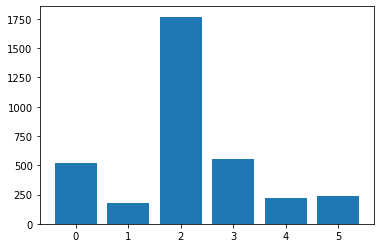

In [4]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder
data = train.values


# split into input and output elements
X, y = data[:, :-1], data[:, -1]
# label encode the target variable
y = LabelEncoder().fit_transform(y)

# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%s, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [5]:
#cleaning
import nltk
import re
import string
nltk.download('stopwords')
nltk.download('wordnet')
stopword=nltk.corpus.stopwords.words('english')
from nltk.stem import WordNetLemmatizer
wl= WordNetLemmatizer()

def clean_text(text):
  text="".join([word.lower() for word in text if word not in string.punctuation])
  tokens = re.split('\W+',text)
  text = [wl.lemmatize(word) for word in tokens if word not in stopword]
  return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(analyzer = clean_text)
X_tfidf = tfidf_vect.fit_transform(train['Sentence'])
print(X_tfidf.shape)

(3476, 6383)


In [7]:
X_tfidf_df=pd.DataFrame(X_tfidf.toarray())
X_tfidf_df.columns=tfidf_vect.get_feature_names()
X_tfidf_df.head()

,,015,1,10,100,1000,10000,100000,10000000,1008,1008a,101,1013,1015,102,1026,104,1044,105,1065,107,107c,1081,1084,1097,10a,10acre,11,110,1102,111,1116,112,113,1130,113637,1140,114073,115,1150,...,œsuccessively,œswayingâ,œswollenâ,œtesting,œtestâ,œthat,œthatâ,œthe,œthere,œthey,œthick,œthis,œto,œtwo,œtwoâ,œunlawfully,œunlawfullyâ,œupon,œvagrancyâ,œvalue,œvery,œvisited,œwaived,œwalked,œwas,œwater,œwe,œwell,œwhat,œwhen,œwhere,œwhile,œwhoever,œwilfullyâ,œwillfullyâ,œwobblyâ,œyes,œyesâ,œyou,œyour
0,0.136318,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Class=Analysis, n=179 (16.667%)
Class=Conclusion, n=179 (16.667%)
Class=Facts, n=179 (16.667%)
Class=Invalid, n=179 (16.667%)
Class=Issue, n=179 (16.667%)
Class=Rule/Law/Holding, n=179 (16.667%)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


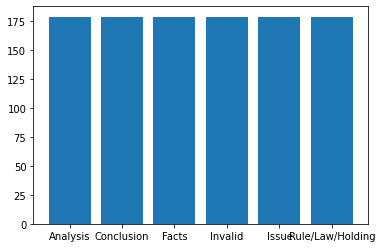

In [8]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

undersampling_Dict={'Facts': 179, 'Invalid': 179, 'Analysis': 179, 'Rule/Law/Holding': 179, 'Issue': 179, 'Conclusion': 179}
oversample = SMOTE("minority")
undersample = RandomUnderSampler(sampling_strategy=undersampling_Dict)
#X, y = oversample.fit_sample(X_tfidf_df, train['Target'])
X, y = undersample.fit_resample(X_tfidf_df, train['Target'])
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%s, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()



In [9]:
test = pd.read_csv(r'/content/drive/My Drive/Research/test_data.csv')

test['Target']=test['Target'].replace(['Others'],'Invalid')
test['Sentence'] = test['Sentence'].apply(lambda x: " ".join(x.lower() for x in str(x).split()))
test['Sentence'] = test['Sentence'].str.replace('[^\w\s]','')
from nltk.corpus import stopwords
words = stopwords.words('english')
test['Sentence'] = test['Sentence'].apply(lambda x: " ".join(x for x in x.split() if x not in words))
t_p = tfidf_vect.transform(test['Sentence'])

In [10]:
import numpy as np
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from xgboost import XGBClassifier



#X, y = make_classification(random_state=1)
counter = Counter(y)
print(counter)
#X_train, x_val, Y_train, y_val = train_test_split(X_tfidf,train['Target'],test_size=0.26,random_state=42)
X_train, x_val, Y_train, y_val = train_test_split(X,y,test_size=0.26,random_state=42)

classifier = XGBClassifier()
classifier.fit(X_train, Y_train)
y_pred = classifier.predict(x_val)
#print(np.unique(y_pred))
#print(type(y_pred))

Accuracy_score = accuracy_score(y_pred,y_val)

print('Validation Accuracy_score: %f' % Accuracy_score)
test_pred = classifier.predict(t_p)
acc_test = accuracy_score(test_pred,test['Target'])
print('Accuracy test data', acc_test)
matrix = confusion_matrix(y_pred, y_val)
print(matrix)


Counter({'Analysis': 179, 'Conclusion': 179, 'Facts': 179, 'Invalid': 179, 'Issue': 179, 'Rule/Law/Holding': 179})
Validation Accuracy_score: 0.521429
Accuracy test data 0.44145873320537427
[[21  8  4  5  4  5]
 [ 5 35  1  5  2  4]
 [ 3  6 25  7  2  5]
 [ 5  1 11 25  4 10]
 [ 3  2  7  3 21  4]
 [ 7  1  1  3  6 19]]


In [11]:

unlabel = pd.read_csv(r'/content/drive/My Drive/Research/Unlabeled_data.csv')
unlabel.head()


,Unnamed: 0,text,Complete
0,0,No motion for rehearing filed.,1
1,1,— Relator is under accusation of killing her h...,1
2,2,From an order of the District Judge of the 39t...,1
3,3,Relator and her husband had been married for a...,1
4,4,The evidence indicates that their family relat...,1


In [12]:
del unlabel['Complete']

In [13]:
del unlabel['Unnamed: 0']

In [14]:
unlabel.head()

,text
0,No motion for rehearing filed.
1,— Relator is under accusation of killing her h...
2,From an order of the District Judge of the 39t...
3,Relator and her husband had been married for a...
4,The evidence indicates that their family relat...


In [15]:
unlabel['text'] = unlabel['text'].apply(lambda x: " ".join(x.lower() for x in str(x).split()))
unlabel['text'] = unlabel['text'].str.replace('[^\w\s]','')
from nltk.corpus import stopwords
words = stopwords.words('english')
unlabel['text'] = unlabel['text'].apply(lambda x: " ".join(x for x in x.split() if x not in words))


In [16]:
from textblob import TextBlob
from textblob import Word
nltk.download('wordnet')
nltk.download('punkt')
unlabel['text'] = unlabel['text'].apply(lambda x: TextBlob(x).words)
unlabel['text'] = unlabel['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x]))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [17]:
unlabel.head()

,text
0,motion rehearing filed
1,relator accusation killing husband virgil clark
2,order district judge 39th judicial district re...
3,relator husband married number year
4,evidence indicates family relation always plea...


In [18]:
len(unlabel)

537703

In [19]:
unlabel_1 = unlabel.loc[:100000]
print("length of unlabel_1",len(unlabel_1))
unlabel_2 = unlabel.loc[100001:200000]
print("length of unlabel_2",len(unlabel_2))
unlabel_3 = unlabel.loc[200001:300000]
print("length of unlabel_3",len(unlabel_3))
unlabel_4 = unlabel.loc[300001:400000]
print("length of unlabel_4",len(unlabel_4))
unlabel_5 = unlabel.loc[400001:]
print("length of unlabel_5",len(unlabel_5))

length of unlabel_1 100001
length of unlabel_2 100000
length of unlabel_3 100000
length of unlabel_4 100000
length of unlabel_5 137702


In [20]:
unlabel_1.head()

,text
0,motion rehearing filed
1,relator accusation killing husband virgil clark
2,order district judge 39th judicial district re...
3,relator husband married number year
4,evidence indicates family relation always plea...


In [21]:
unlabel_2.reset_index(inplace=True)
del unlabel_2['index']
unlabel_2.head()

,text
0,responding conclusion regarding evidence annou...
1,conviction transporting intoxicating liquor pu...
2,bill exception case filed late
3,motion new trial overruled october 22 1927 ord...
4,thereafter december 10th extension order made ...


In [22]:
unlabel_3.reset_index(inplace=True)
del unlabel_3['index']
unlabel_3.head()

,text
0,another man carrying clothes
1,officer testified appellant several item cloth...
2,investigation followed report breaking entry a...
3,appellant present
4,warrant arrest issued officer went hotel waite...


In [23]:
unlabel_4.reset_index(inplace=True)
del unlabel_4['index']
unlabel_4.head()

,text
0,statute final judgment appeal court lie senten...
1,sentence must pronounced term court judgment r...
2,court sentence defendant vacation
3,court adjourned authority case ceased notice a...
4,pronouncing sentence authorized vacation autho...


In [24]:
unlabel_5.reset_index(inplace=True)
del unlabel_5['index']
unlabel_5.head()

,text
0,member federal reserve bank
1,opinion state case
2,conviction violating state cigarette law punis...
3,find record bill exception bringing forward co...
4,brief appellant complains lack testimony


In [25]:
classifier.classes_

array(['Analysis', 'Conclusion', 'Facts', 'Invalid', 'Issue',
       'Rule/Law/Holding'], dtype=object)

In [26]:
x_un1 = tfidf_vect.transform(unlabel_1['text'])


In [27]:
x_un1.shape
pred_unlabel_1 = classifier.predict_proba(x_un1)
pred_unlabel_1



array([[0.1301998 , 0.31766477, 0.22469327, 0.15802301, 0.07055804,
        0.09886108],
       [0.19042645, 0.13041127, 0.20025499, 0.23111986, 0.10319613,
        0.14459135],
       [0.19508436, 0.11707364, 0.27536768, 0.15096027, 0.13408367,
        0.12743041],
       ...,
       [0.14321816, 0.24081595, 0.17487271, 0.16398995, 0.17138496,
        0.10571823],
       [0.15134522, 0.10364696, 0.15915664, 0.1836871 , 0.08201718,
        0.32014692],
       [0.39577404, 0.09696908, 0.1345383 , 0.17185232, 0.0767329 ,
        0.12413341]], dtype=float32)

In [28]:
print(len(pred_unlabel_1))
print(np.unique(pred_unlabel_1))


100001
[0.00188531 0.0020714  0.00245516 ... 0.97519433 0.97633773 0.977785  ]


In [36]:
Threshold= 0.90

In [37]:
import numpy as np
pos=[]
large=[]
ind = []
i=0
for j in pred_unlabel_1:
  if max(j)> Threshold:
    ind.append(np.argmax(j))
    large.append(max(j))
    pos.append(i)
  i+=1


print(ind)
print(large)
print(pos)
print(type(pos))
print(len(ind))
print(len(large))
print(len(pos))

[1, 1, 1, 4, 1, 1, 4, 4, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 1, 1, 1, 2, 1, 4, 1, 4, 1, 1, 4, 1, 4, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 4, 4, 1, 1, 1, 1, 1, 1, 1, 3, 1, 4, 4, 1, 1, 1, 1, 1, 4, 1, 4, 4, 1, 4, 1, 1, 1, 1, 4, 4, 1, 4, 4, 1, 4, 1, 1, 1, 1, 4, 1, 4, 1, 1, 4, 1, 4, 1, 1, 4, 4, 1, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 4, 5, 1, 4, 4, 1, 1, 4, 1, 4, 4, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 2, 1, 4, 1, 1, 1, 4, 4, 1, 1, 1, 1, 1, 4, 4, 1, 1, 4, 1, 1, 4, 1, 1, 4, 1, 1, 1, 4, 1, 1, 1, 1, 1, 4, 4, 1, 1, 1, 4, 1, 4, 1, 1, 1, 1, 1, 4, 1, 1, 4, 4, 4, 4, 1, 1, 1, 1, 5, 4, 1, 4, 4, 1, 1, 4, 4, 4, 1, 4, 1, 1, 1, 4, 1, 1, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 1, 4, 1, 3, 1, 1, 4, 1, 4, 1, 1, 5, 5, 1, 1, 4, 4, 4, 1, 4, 4, 1, 1, 1, 4, 1, 1, 1, 4, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 4, 4, 1, 4, 4, 4, 4, 1, 1, 4, 1, 1, 4, 4, 4, 1, 1, 4, 4, 4, 4, 1, 4, 1, 1, 1, 4, 4, 1, 4, 1, 1, 4, 4, 4, 1, 2, 2, 1, 4, 4, 1, 1, 1, 1, 

In [38]:
unlabel_1 = unlabel_1.loc[pos,:]
print(len(unlabel_1))
unlabel_1.head()

KeyError: ignored

In [32]:
class_x_un1 = tfidf_vect.transform(unlabel_1['text'])

ValueError: ignored

In [ ]:
class_x_un1.shape

In [ ]:

class_pred_unlabel_1 = classifier.predict(class_x_un1)
class_pred_unlabel_1


In [ ]:
print(len(class_pred_unlabel_1))

In [ ]:
unlabel_1['Target']=class_pred_unlabel_1
unlabel_1.head()

In [ ]:
train = train.rename(columns={'Sentence':'text'})
train.head()

In [ ]:
frame_1 = [train,unlabel_1]
train_1 = pd.concat(frame_1)
print(len(train))
print(len(unlabel_1))
print(len(train_1))

In [ ]:
from sklearn.metrics import classification_report
x_train_1 = tfidf_vect.transform(train_1['text'])
x_train_1.shape
X_train, x_val, Y_train, y_val = train_test_split(x_train_1,train_1['Target'],test_size=0.25,random_state=2)
classifier_1 = XGBClassifier()
classifier_1.fit(X_train, Y_train)
y_pred = classifier_1.predict(x_val)
print(np.unique(y_pred))
print(type(y_pred))


Accuracy_score = accuracy_score(y_pred,y_val)

print('Validation ------- Accuracy_score: %f' % Accuracy_score)

test_pred = classifier_1.predict(t_p)
acc_test = accuracy_score(test_pred,test['Target'])
print('Test ------Accuracy score ', acc_test)
matrix = confusion_matrix(y_pred, y_val)
print(matrix)
print("---------validation--------------")
print(classification_report(y_val,y_pred))
print("----------test---------------------")
print(classification_report(test['Target'],test_pred))

Second set of unlabeled data 

In [ ]:
x_un2 = tfidf_vect.transform(unlabel_2['text'])


In [ ]:

pred_unlabel_2 = classifier_1.predict_proba(x_un2)
pred_unlabel_2

In [ ]:
print(len(pred_unlabel_2))
print(np.unique(pred_unlabel_2))

In [ ]:
import numpy as np
pos=[]
large=[]
ind = []
i=0
for j in pred_unlabel_2:
  if max(j)> Threshold:
    ind.append(np.argmax(j))
    large.append(max(j))
    pos.append(i)
  i+=1


print(ind)
print(large)
print(pos)
print(type(pos))
print(len(ind))
print(len(large))
print(len(pos))

In [ ]:
unlabel_2 = unlabel_2.loc[pos,:]
print(len(unlabel_2))
unlabel_2.head()

In [ ]:
class_x_un2 = tfidf_vect.transform(unlabel_2['text'])

In [ ]:
class_x_un1.shape

In [ ]:
class_pred_unlabel_2 = classifier_1.predict(class_x_un2)
class_pred_unlabel_2

In [ ]:
print(len(class_pred_unlabel_2))

In [ ]:
unlabel_2['Target']=class_pred_unlabel_2
unlabel_2.head()

In [ ]:
train_1.head()

In [ ]:
frame_2 = [train_1,unlabel_2]
train_2 = pd.concat(frame_2)
print(len(train_1))
print(len(unlabel_2))
print(len(train_2))

In [ ]:
train_2

In [ ]:
from sklearn.metrics import classification_report
x_train_2 = tfidf_vect.transform(train_2['text'])
x_train_2.shape
X_train, x_val, Y_train, y_val = train_test_split(x_train_2,train_2['Target'],test_size=0.25,random_state=2)
classifier_2 = XGBClassifier()
classifier_2.fit(X_train, Y_train)
y_pred = classifier_2.predict(x_val)
print(np.unique(y_pred))
print(type(y_pred))


Accuracy_score = accuracy_score(y_pred,y_val)

print('Validation ------- Accuracy_score: %f' % Accuracy_score)

test_pred = classifier_2.predict(t_p)
acc_test = accuracy_score(test_pred,test['Target'])
print('Test ------Accuracy score ', acc_test)
matrix = confusion_matrix(y_pred, y_val)
print(matrix)
print("---------validation--------------")
print(classification_report(y_val,y_pred))
print("----------test---------------------")
print(classification_report(test['Target'],test_pred))

Unlabelled 3:

In [ ]:
x_un3 = tfidf_vect.transform(unlabel_3['text'])


In [ ]:

pred_unlabel_3 = classifier_2.predict_proba(x_un3)
pred_unlabel_3

In [ ]:
print(len(pred_unlabel_2))
print(np.unique(pred_unlabel_2))

In [ ]:
import numpy as np
pos=[]
large=[]
ind = []
i=0
for j in pred_unlabel_3:
  if max(j)> Threshold:
    ind.append(np.argmax(j))
    large.append(max(j))
    pos.append(i)
  i+=1


print(ind)
print(large)
print(pos)
print(type(pos))
print(len(ind))
print(len(large))
print(len(pos))

In [ ]:
unlabel_3 = unlabel_3.loc[pos,:]
print(len(unlabel_3))
unlabel_3.head()

In [ ]:
class_x_un3 = tfidf_vect.transform(unlabel_3['text'])

In [ ]:
class_x_un3.shape

In [ ]:
class_pred_unlabel_3 = classifier_2.predict(class_x_un3)
class_pred_unlabel_3

In [ ]:
print(len(class_pred_unlabel_3))

In [ ]:
unlabel_3['Target']=class_pred_unlabel_3
unlabel_3.head()

In [ ]:
train_2.head()

In [ ]:
frame_3 = [train_2,unlabel_3]
train_3 = pd.concat(frame_3)
print(len(train_2))
print(len(unlabel_3))
print(len(train_3))

In [ ]:
train_3

In [ ]:
from sklearn.metrics import classification_report
x_train_3 = tfidf_vect.transform(train_3['text'])
x_train_3.shape
X_train, x_val, Y_train, y_val = train_test_split(x_train_3,train_3['Target'],test_size=0.25,random_state=2)
classifier_3 = XGBClassifier()
classifier_3.fit(X_train, Y_train)
y_pred = classifier_3.predict(x_val)
print(np.unique(y_pred))
print(type(y_pred))


Accuracy_score = accuracy_score(y_pred,y_val)

print('Validation ------- Accuracy_score: %f' % Accuracy_score)

test_pred = classifier_3.predict(t_p)
acc_test = accuracy_score(test_pred,test['Target'])
print('Test ------Accuracy score ', acc_test)
matrix = confusion_matrix(y_pred, y_val)
print(matrix)
print("---------validation--------------")
print(classification_report(y_val,y_pred))
print("----------test---------------------")
print(classification_report(test['Target'],test_pred))

Unlabeled 4

In [ ]:
x_un4 = tfidf_vect.transform(unlabel_4['text'])


In [ ]:

pred_unlabel_4 = classifier_3.predict_proba(x_un4)
pred_unlabel_4

In [ ]:
print(len(pred_unlabel_2))
print(np.unique(pred_unlabel_2))

In [ ]:
import numpy as np
pos=[]
large=[]
ind = []
i=0
for j in pred_unlabel_4:
  if max(j)> Threshold:
    ind.append(np.argmax(j))
    large.append(max(j))
    pos.append(i)
  i+=1


print(ind)
print(large)
print(pos)
print(type(pos))
print(len(ind))
print(len(large))
print(len(pos))

In [ ]:
unlabel_4 = unlabel_4.loc[pos,:]
print(len(unlabel_4))
unlabel_4.head()

In [ ]:
class_x_un4 = tfidf_vect.transform(unlabel_4['text'])

In [ ]:
class_x_un4.shape

In [ ]:
class_pred_unlabel_4 = classifier_3.predict(class_x_un4)
class_pred_unlabel_4

In [ ]:
print(len(class_pred_unlabel_4))

In [ ]:
unlabel_4['Target']=class_pred_unlabel_4
unlabel_4.head()

In [ ]:
train_3.head()

In [ ]:
frame_4 = [train_3,unlabel_4]
train_4 = pd.concat(frame_4)
print(len(train_3))
print(len(unlabel_4))
print(len(train_4))
train_4

In [ ]:
from sklearn.metrics import classification_report
x_train_4 = tfidf_vect.transform(train_4['text'])
x_train_4.shape
X_train, x_val, Y_train, y_val = train_test_split(x_train_4,train_4['Target'],test_size=0.25,random_state=2)
classifier_4 = XGBClassifier()
classifier_4.fit(X_train, Y_train)
y_pred = classifier_4.predict(x_val)
print(np.unique(y_pred))
print(type(y_pred))


Accuracy_score = accuracy_score(y_pred,y_val)

print('Validation ------- Accuracy_score: %f' % Accuracy_score)

test_pred = classifier_4.predict(t_p)
acc_test = accuracy_score(test_pred,test['Target'])
print('Test ------Accuracy score ', acc_test)
matrix = confusion_matrix(y_pred, y_val)
print(matrix)
print("---------validation--------------")
print(classification_report(y_val,y_pred))
print("----------test---------------------")
print(classification_report(test['Target'],test_pred))

Unlabeld 5

In [ ]:
x_un5 = tfidf_vect.transform(unlabel_5['text'])


In [ ]:
x_un5.shape

In [ ]:
pred_unlabel_5 = classifier_4.predict_proba(x_un5)
pred_unlabel_5

In [ ]:
print(len(pred_unlabel_5))
print(np.unique(pred_unlabel_5)) 

In [ ]:
import numpy as np
pos=[]
large=[]
ind = []
i=0
for j in pred_unlabel_5:
  if max(j)> Threshold:
    ind.append(np.argmax(j))
    large.append(max(j))
    pos.append(i)
  i+=1


print(ind)
print(large)
print(pos)
print(type(pos))
print(len(ind))
print(len(large))
print(len(pos))

In [ ]:
unlabel_5 = unlabel_5.loc[pos,:]
print(len(unlabel_5))
unlabel_5.head()

In [ ]:
class_x_un5 = tfidf_vect.transform(unlabel_5['text'])

In [ ]:
class_x_un5.shape

In [ ]:
class_pred_unlabel_5 = classifier_4.predict(class_x_un5)
class_pred_unlabel_5

In [ ]:
print(len(class_pred_unlabel_5))

In [ ]:
unlabel_5['Target']=class_pred_unlabel_5
unlabel_5.head()

In [ ]:
train_4.head()


In [ ]:
print(len(train_4))

In [ ]:
frame_5 = [train_4,unlabel_5]
train_5 = pd.concat(frame_5)
print(len(train_4))
print(len(unlabel_5))
print(len(train_5))

In [ ]:
from sklearn.metrics import classification_report
x_train_5 = tfidf_vect.transform(train_5['text'])
x_train_5.shape
X_train, x_val, Y_train, y_val = train_test_split(x_train_5,train_5['Target'],test_size=0.25,random_state=2)
classifier_5 = XGBClassifier()
classifier_5.fit(X_train, Y_train)
y_pred = classifier_5.predict(x_val)
print(np.unique(y_pred))
print(type(y_pred))


Accuracy_score = accuracy_score(y_pred,y_val)

print('Validation ------- Accuracy_score: %f' % Accuracy_score)

test_pred = classifier_5.predict(t_p)
acc_test = accuracy_score(test_pred,test['Target'])
print('Test ------Accuracy score ', acc_test)
matrix = confusion_matrix(y_pred, y_val)
print(matrix)
print("---------validation--------------")
print(classification_report(y_val,y_pred))
print("----------test---------------------")
print(classification_report(test['Target'],test_pred))